In [5]:
# import gdown
# TODO: uncomment to download data

# cuomo_url = f'https://drive.google.com/uc?id=1ai2-eEwH2NiBQFbWj8XjdDTUmKwgmxeC'
# metadata_url = f'https://drive.google.com/uc?id=1Xp0gUAlhveeVMyHNTurJiGIEcnaXznXy'

# # Download the files - cuomo dataset and metadata
# gdown.download(cuomo_url, "cuomo_expr_matrix_with_MT_RP.csv", quiet=False)
# gdown.download(metadata_url, "metadata.csv", quiet=False)

In [4]:
# !pip install /Users/macbookpro/Desktop/crow

In [17]:
# !pip install setuptools
# !pip install scikit-learn-extra

In [2]:
# !pip install --upgrade setuptools

In [5]:
from setuptools import setup

In [6]:
from sklearn_extra.cluster import KMedoids

For further details on the calculations, refer to the package’s technical report.

In [7]:
import warnings
import pandas as pd
import scanpy as sc
import scanpy.external as sce
from scipy.io import mmread
import numpy as np

warnings.filterwarnings("ignore")

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

import pandas as pd

import pickle

In [9]:
from sklearn.cluster import SpectralClustering 

In [1]:
from crow import (
    StochasticClusteringRunner,
    ParameterOptimizer,
    ParameterSearcher,
    GeneticAlgorithmFeatureSelector,
    PerturbationRobustnessTester,
    KFoldClusteringValidator,
    plot_scatter_ecc,
    plot_optimization_of_parameter_boxplot,
    plot_heatmap,
    plot_ga_fitness_evolution,
    plot_kfold_scores
)

/Users/macbookpro/Desktop/Crow/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
data = pd.read_csv(
    "data/cuomo_expr_matrix_with_MT_RP.csv", index_col="gene_name"
)

cell_metadata = pd.read_csv('data/metadata.csv', sep=',')
cell_metadata.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [26]:
# Transposing the raw data because scanpy expects genes on columns and cells on rows (opposite of Seurat).
adata = sc.AnnData(data.T)
adata.obs = cell_metadata

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=500) 

In [27]:
# Get highly variable genes as a list
highly_variable_genes = adata.var_names[adata.var["highly_variable"]].tolist()

Let's now normalise and standardise the data and then subset it to only include the 1000 HV genes.

In [28]:
# Normalise data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Scale the data
sc.pp.scale(adata)

sc.tl.pca(adata, svd_solver='arpack')

# Run harmony batch correction
sce.pp.harmony_integrate(adata, 'day.ident')

# Get pca embdeddings after batch correction
pca_embs = adata.obsm['X_pca_harmony']

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep="X_pca_harmony") 
sc.tl.umap(adata)

# Get scaled data.
scaled_data = adata.to_df()

2025-01-10 15:00:15,229 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-10 15:00:17,539 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-10 15:00:17,564 - harmonypy - INFO - Iteration 1 of 10
2025-01-10 15:00:19,154 - harmonypy - INFO - Iteration 2 of 10
2025-01-10 15:00:21,907 - harmonypy - INFO - Converged after 2 iterations


In [29]:
scaled_data_subset = scaled_data[highly_variable_genes]
scaled_data_subset.index = data.T.index

scaled_data_subset.head()

gene_name,NPPA,NPPB,SLC30A2,TENT5B,LCK,GJA4,SLC2A1,DMBX1,SLC5A9,ELAVL4,...,H1-0,APOBEC3G,CACNA1I,SERHL2,D21S2088E,RCAN1,DSCAM,LINC00479,ERVH48-1,LINC02575
X21241_6_14,2.136469,0.719023,-0.106623,-0.456136,-0.544734,-0.190172,-1.221928,-0.062205,-0.225074,-0.224847,...,-1.022934,0.970377,-0.103330,0.769625,-0.577124,-0.194243,-0.357047,-0.463814,0.242953,-0.273429
X21241_6_39,0.005472,-0.555815,-0.106623,-0.456136,-0.544734,-0.190172,1.200503,-0.062205,-0.225074,-0.224847,...,0.020589,1.093809,0.270724,1.630292,0.678390,-0.194243,-0.357047,-0.463814,-0.563318,-0.273429
X21241_6_41,-0.539477,1.147459,-0.106623,-0.456136,-0.544734,-0.190172,-1.203338,-0.062205,-0.225074,-0.224847,...,-0.757983,1.090986,-0.103330,-0.447325,-0.577124,-0.194243,-0.357047,-0.463814,-0.563318,-0.273429
X21241_6_47,2.113742,0.670647,-0.106623,-0.456136,-0.544734,-0.190172,-0.733450,0.381778,-0.225074,-0.224847,...,-0.531017,1.436913,-0.103330,1.799940,-0.577124,-0.194243,5.119318,-0.463814,-0.563318,-0.273429
X21241_6_52,0.810844,0.537172,-0.106623,-0.456136,-0.544734,-0.190172,0.535727,-0.062205,-0.225074,-0.224847,...,-1.022934,-0.229647,-0.103330,0.188143,-0.577124,-0.194243,-0.357047,-0.255755,-0.143416,-0.273429


## Clustering with SpectralClustering

The `crow` package is highly versatile, enabling users to use their preferred clustering algorithm (e.g., any algorithm with a fit or fit_predict method or one that directly returns cluster labels).

To showcase `crow`‘s clustering evaluation capabilities, we will perform repeated stochastic clustering using Spectral Clustering on the PCA embeddings. By passing `scikit-learn`’s `SpectralClustering` implementation to `StochasticClusteringRunner`, we can execute the algorithm multiple times (n_runs) while varying the random seed for each run.

After calling the `run` function, the returned dictionary includes Element-Centric Consistency (ECC) results and majority voting labels, representing the most likely cluster for each point. This can give more insights about how stable, reproducible, and thus trustworthy the clustering results are.

In [30]:
# Helper function to plot results on umap after clustering.
def visualise_ecc_labels(adata, ecc, ecc_adata_name, labels, labels_adata_name):
    adata.obs[ecc_adata_name] = ecc
    sc.pl.umap(adata, color=ecc_adata_name)

    adata.obs[labels_adata_name] = labels
    adata.obs[labels_adata_name] = adata.obs[labels_adata_name].astype("category")
    sc.pl.umap(adata, color=labels_adata_name)

Let's start by running Spectral Clustering with its default parameters.

In [31]:
from sklearn.mixture import GaussianMixture

In [32]:
# Trying to cluster with default number of clusters SpectralClustering
repeated_spectral_func = StochasticClusteringRunner(
    GaussianMixture, "random_state", n_runs=30, verbose=False, n_components=5
)
results_repeated_spectral = repeated_spectral_func.run(scaled_data_subset)

In [39]:
np.median(results_repeated_spectral['ecc'])

0.6615791150483812

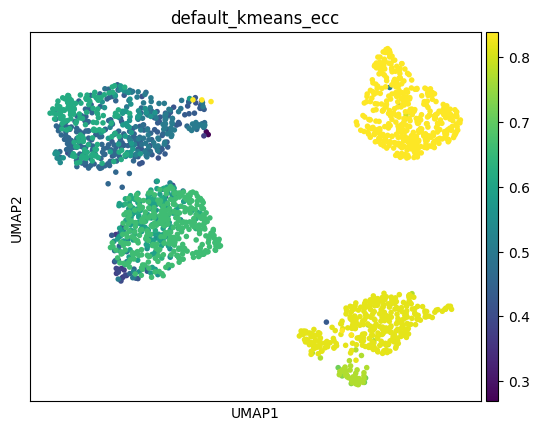

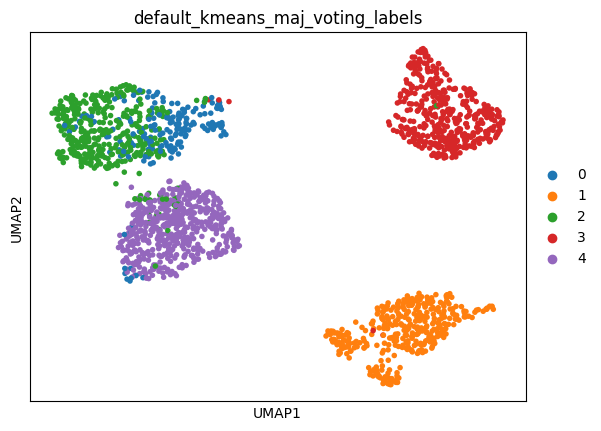

In [33]:
visualise_ecc_labels(
    adata,
    results_repeated_spectral["ecc"],
    "default_kmeans_ecc",
    results_repeated_spectral["majority_voting_labels"],
    "default_kmeans_maj_voting_labels",
)

We can optimise any parameter values of the number of clusters and k-means initialisation algorithm using `crow`'s `ParameterSearcher` class.

In [44]:
# Find the optimal parameters based on ECC - similar to fine tuning in supervised learning.
param_grid = {"n_components": np.arange(3, 10, 1), "covariance_type": ["full", "tied"], "init_params": ["kmeans", "k-means++", "random"]}

parameter_searcher = ParameterSearcher(
    clustering_algo=GaussianMixture,
    parameter_name_seed="random_state",
    param_grid=param_grid,
    n_runs=30,
    verbose=True,
)
searcher_results_ecc_df, stochastic_clustering_results = parameter_searcher.run(scaled_data_subset)

Testing parameters: {'n_components': 3, 'covariance_type': 'full', 'init_params': 'kmeans'}

 Median ECC:  0.7266139518825812
--------------------------------------------------------------
Testing parameters: {'n_components': 3, 'covariance_type': 'full', 'init_params': 'k-means++'}

 Median ECC:  0.5060561401895526
--------------------------------------------------------------
Testing parameters: {'n_components': 3, 'covariance_type': 'full', 'init_params': 'random'}

 Median ECC:  0.3159969972922484
--------------------------------------------------------------
Testing parameters: {'n_components': 3, 'covariance_type': 'tied', 'init_params': 'kmeans'}

 Median ECC:  0.727628196511146
--------------------------------------------------------------
Testing parameters: {'n_components': 3, 'covariance_type': 'tied', 'init_params': 'k-means++'}

 Median ECC:  0.835837053526679
--------------------------------------------------------------
Testing parameters: {'n_components': 3, 'covariance

In [78]:
searcher_results_ecc_df.sort_values(by="median_ecc", ascending=False).head()

,params,ecc,median_ecc
4,"{'n_components': 3, 'covariance_type': 'tied',...","[0.8457506409334926, 0.8131891806111272, 0.836...",0.835837
18,"{'n_components': 6, 'covariance_type': 'full',...","[0.4889227345856322, 0.477578274715157, 0.7375...",0.750701
21,"{'n_components': 6, 'covariance_type': 'tied',...","[0.48683628079062946, 0.4753335186116461, 0.73...",0.749210
10,"{'n_components': 4, 'covariance_type': 'tied',...","[0.7841951733997609, 0.6891318844619919, 0.717...",0.745432
24,"{'n_components': 7, 'covariance_type': 'full',...","[0.46061723817692635, 0.5329914482649237, 0.67...",0.743208


In [93]:
searcher_results_ecc_df.sort_values(by="median_ecc", ascending=False)[["params", "median_ecc"]].to_csv("output_experiments/grid_searcher_gaussian_mixture_cuomo.csv", index=False)

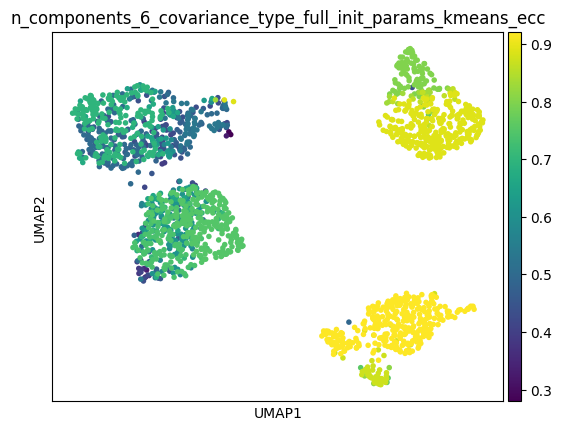

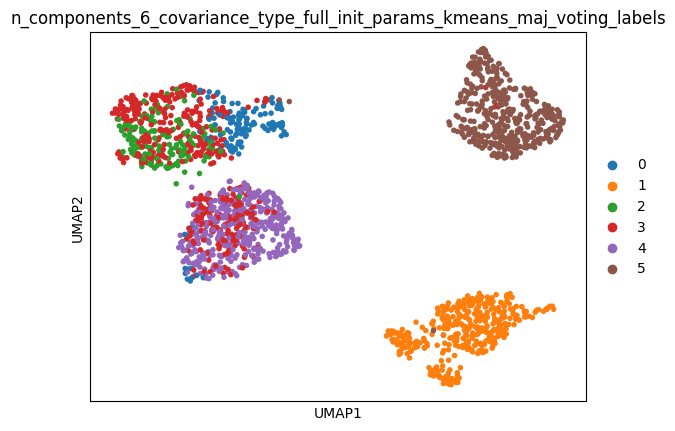

In [58]:

visualise_ecc_labels(
    adata,
    stochastic_clustering_results['n_components_6_covariance_type_full_init_params_kmeans']["ecc"],
    "n_components_6_covariance_type_full_init_params_kmeans_ecc",
    stochastic_clustering_results['n_components_6_covariance_type_full_init_params_kmeans']["majority_voting_labels"],
    "n_components_6_covariance_type_full_init_params_kmeans_maj_voting_labels",
)


# Genes optimisation

In [62]:
ga_fs = GeneticAlgorithmFeatureSelector(GaussianMixture, 'random_state', verbose=True, n_components=6, covariance_type="full", init_params="kmeans", n_generations_no_change=5)
ga_results = ga_fs.run(scaled_data_subset)

Gen 0 - Best ECC: 0.8055
Gen 1 - Best ECC: 0.8314
Gen 2 - Best ECC: 0.8314
Gen 3 - Best ECC: 0.8729
Gen 4 - Best ECC: 0.8729
Gen 5 - Best ECC: 0.8729
Gen 6 - Best ECC: 0.8729
Gen 7 - Best ECC: 0.8729


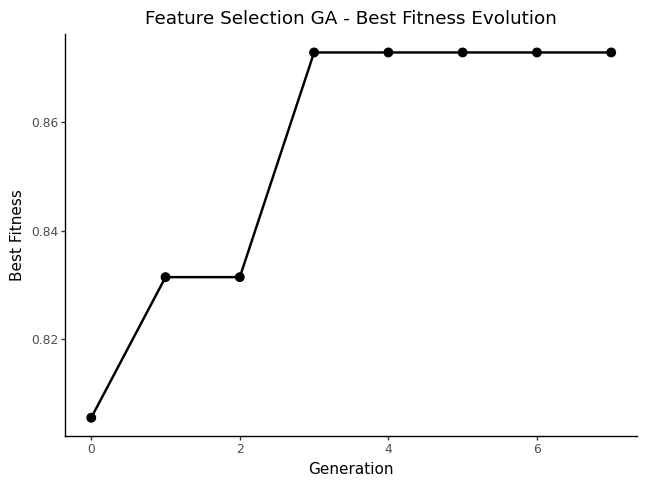

In [75]:
plot_ga_fitness_evolution(ga_results['history'])

In [80]:
scaled_data_subset[ga_results['best_features']].shape

(1880, 281)

In [81]:
# Trying to cluster with default number of clusters SpectralClustering
optimized_GM_func = StochasticClusteringRunner(
    GaussianMixture, "random_state", n_runs=30, verbose=False, n_components=6, covariance_type="full", init_params="kmeans"
)
results_repeated_gm = optimized_GM_func.run(scaled_data_subset[ga_results['best_features']])

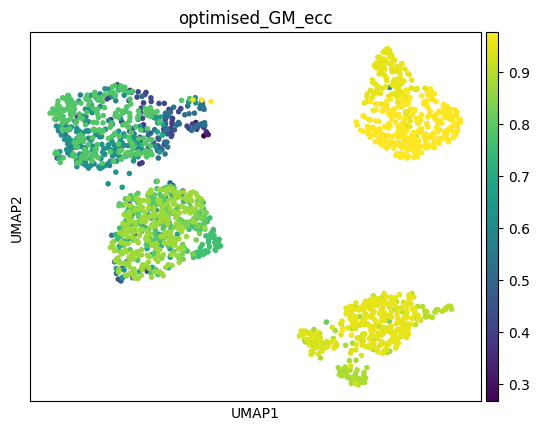

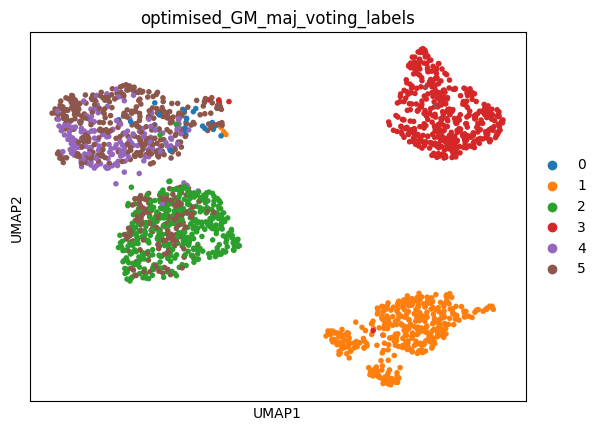

In [84]:
visualise_ecc_labels(
    adata,
    results_repeated_gm["ecc"],
    "optimized_GM_ecc",
    results_repeated_gm["majority_voting_labels"],
    "optimized_GM_maj_voting_labels",
)

In [83]:
np.median(results_repeated_gm["ecc"])

0.8728533614616834